In [1]:
#make sure about the cuda version
import numpy as np
import webdataset as wds
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms 
import os
import random
from itertools import islice
import matplotlib.pyplot as plt
import pickle
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
PATH_TO_DATA = "/glade/scratch/yiwenz/TransferLearningData/rand_sharded_data_all_Daily/" 
#PATH_TO_DATA = "/glade/scratch/yiwenz/TransferLearningData/rand_shard_data/"

In [2]:
#8 channels: ['Red', 'Green', 'Blue', "NIR", "SWIR1","ndbi","ndvi","elevation"]

image_normalize = transforms.Normalize(
                  mean=[0, 0, 0, 0, 0, 0, 0, 4.1459e+02],
                  std=[1, 1, 1, 1, 1, 1, 1, 8.9265e+01]
)
image_rotate = transforms.RandomRotation(90)
#image mean(no clip of elev): [1.8218e-01,  1.4804e-01,  1.0894e-01,  2.6186e-01,  2.5452e-01, -9.3340e-03,  9.4021e-02,  4.1459e+02]
#image std (no clip of elev): [5.6672e-02, 4.0446e-02, 3.3400e-02, 6.2702e-02, 7.1029e-02, 5.7446e-02, 7.2435e-02, 8.9265e+01]

# forcing_normalize = transforms.Normalize(
#                   mean=[3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00],
#                   std=[6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]
# )

forcing_mean = torch.from_numpy(np.array([3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00]))
forcing_std = torch.from_numpy(np.array([6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]))
# forcing mean:[3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02, 2.7644e+00]
# forcing std: [6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00, 1.5957e+00]

lst_mean = torch.from_numpy(np.array([315.1010]))
lst_std = torch.from_numpy(np.array([10.9206]))
#lst mean:315.1010
#lst std: 10.9206

In [3]:
def create_train_test(path_to_data, train_perc, test_perc):
    random.seed(42)
    files = []
    for dirpath, dirnames, filenames in os.walk(path_to_data):
        files.extend(filenames)
    
    saturated = files[:-1] #-1
    unsaturated = files[-1] #-1
    
    dataset = wds.WebDataset(path_to_data + "/" + unsaturated)
    counter = 0
    for data in dataset:
        counter += 1
    
    total_files = counter + len(saturated) * 10000
    training_data = total_files * train_perc //10000
    test_data_files = total_files * test_perc //10000

    training_data = random.sample(files, int(training_data))
    test_data = [file for file in files if file not in training_data]
    test_data = random.sample(test_data, int(test_data_files))
    # Get sample sizes of train and test data
    training_samples = 0
    testing_samples = 0
    
    for path in training_data:
        if path in saturated:
            training_samples += 10000
        elif path in unsaturated:
            training_samples += counter
            
    for path in test_data:
        if path in saturated:
            testing_samples += 10000
        elif path in unsaturated:
            testing_samples += counter
            
            
    # Convert to filename lists 
    training_filepath = []
    for dat in training_data:
#        print(dat[6:12])
        training_filepath.append(dat[6:12])
    training_path = path_to_data + "shard-" + "{" + ",".join(training_filepath) + "}" + ".tar"
    print(training_path)
    
    testing_filepath = []
    for dat in test_data:
        testing_filepath.append(dat[6:12])
    testing_path = path_to_data + "shard-{" + ",".join(testing_filepath) +"}.tar"
    train_data = wds.WebDataset(training_path).shuffle(30000, initial=30000).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
    test_data = wds.WebDataset(testing_path).decode("rgb").shuffle(30000, initial=30000).rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
#    print(testing_path)
    
    all_filepath = []
    for dat in saturated:
#        print(dat[6:12])
        all_filepath.append(dat[6:12])
    all_path = path_to_data + "shard-" + "{" + ",".join(all_filepath) + "}" + ".tar"
#    print(all_path)
    all_data = wds.WebDataset(all_path).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
   
    
    return (train_data, training_samples), (test_data, testing_samples),all_data
    
(train_data, training_samples_len), (test_data, testing_samples_len), all_data = create_train_test(PATH_TO_DATA, 0.5, 0.1)

/glade/scratch/yiwenz/TransferLearningData/rand_sharded_data_all_Daily/shard-{000230,000223,000464,000711,000186,000894,001127,000132,001173,001171,000058,000154,001014,000655,000086,000271,000373,000866,001183,001072,000438,000999,000940,000031,000494,001151,000387,000317,000308,000278,000646,000236,000248,000667,000671,000404,000564,000575,000496,000393,000410,001041,000288,000596,000855,001221,000224,000521,000589,000798,000267,001043,000874,001196,000875,000234,000649,000713,000254,000126,000872,001011,000213,000889,001044,000064,000840,000246,000111,000415,001122,000277,000966,000493,000309,000513,000421,000715,000311,000631,000572,000517,000992,001026,000322,000461,000714,000956,000321,000582,000079,001108,000545,000910,000073,000282,000704,000663,000678,000054,001109,000601,000272,001051,000607,000423,000936,000518,000462,000851,000924,000024,000645,000603,000538,000369,000338,000255,000557,001048,000654,000185,000418,000612,000954,000653,000480,000979,000001,000364,000368,00055

In [7]:
def get_mean_and_std(dataloader):
    img_channels_sum, img_channels_squared_sum, forcing_channels_sum, forcing_channels_squared_sum, lst_channels_sum, lst_channels_squared_sum, num_batches = 0, 0, 0, 0, 0, 0, 0
    for img, forcing, lst in dataloader:
        # Mean over batch, height and width, but not over the channels
        img[:,:5,] = torch.clip(img[:,:5,], min=0, max=1)
        image[:,5:7,] = torch.clip(image[:,5:7,], min=-1, max=1)
#        img[:,-1,] = torch.clip(img[:,-1,], min=0, max=600)
        
        img_channels_sum += torch.mean(img, dim=[0,2,3])
        img_channels_squared_sum += torch.mean(img**2, dim=[0,2,3])
        
        forcing_channels_sum += torch.mean(forcing, dim=[0])
        forcing_channels_squared_sum += torch.mean(forcing**2, dim=[0])
        lst_channels_sum += torch.mean(lst, dim=[0])
        lst_channels_squared_sum += torch.mean(lst**2, dim=[0])
        
        num_batches += 1
    
    img_mean = img_channels_sum / num_batches
    forcing_mean = forcing_channels_sum / num_batches
    lst_mean = lst_channels_sum / num_batches
    # std = sqrt(E[X^2] - (E[X])^2)
    img_std = (img_channels_squared_sum / num_batches - img_mean ** 2) ** 0.5
    forcing_std = (forcing_channels_squared_sum / num_batches - forcing_mean ** 2) ** 0.5
    lst_std = (lst_channels_squared_sum / num_batches - lst_mean ** 2) ** 0.5
    

    return img_mean, img_std, forcing_mean, forcing_std, lst_mean, lst_std

In [8]:
loader = torch.utils.data.DataLoader(all_data, batch_size=1024, num_workers=8)
get_mean_and_std(loader)

(tensor([ 1.8218e-01,  1.4804e-01,  1.0894e-01,  2.6186e-01,  2.5452e-01,
         -9.3340e-03,  9.4021e-02,  4.1459e+02], dtype=torch.float64),
 tensor([5.6672e-02, 4.0446e-02, 3.3400e-02, 6.2702e-02, 7.1029e-02, 5.7446e-02,
         7.2435e-02, 8.9265e+01], dtype=torch.float64),
 tensor([3.6346e+02, 8.3282e+02, 5.5716e-05, 9.6421e+04, 5.2780e-03, 3.0339e+02,
         2.7644e+00]),
 tensor([6.5498e+01, 1.7130e+02, 3.7665e-04, 1.0908e+03, 2.9168e-03, 8.6245e+00,
         1.5957e+00]),
 tensor(315.1010, dtype=torch.float64),
 tensor(10.9206, dtype=torch.float64))

In [4]:
def process_data(image, forcing, lst):
    image, forcing, lst = image.to(DEVICE).to(torch.float32), forcing.to(DEVICE), lst.to(DEVICE)
    # Image Transformations
    image[:,7,] = torch.clip(image[:,7,], min=0, max=600)
    image[:,:5,] = torch.clip(image[:,:5,], min=0, max=1)
    image[:,5:7,] = torch.clip(image[:,5:7,], min=-1, max=1)
    image = image_normalize(image)
    image = image[:,:7,:] #np.array([5,6])
#    image = image_rotate(image)
    # Forcing Transformation
    forcing = torch.div(torch.sub(forcing, forcing_mean), forcing_std).to(torch.float32)
#    forcing = forcing.unsqueeze(2).unsqueeze(3)
#    forcing = forcing.repeat(1,1,33,33)
    # LST Transformation
#     lst = torch.div(torch.sub(lst, lst_mean), lst_std).to(torch.float32).view(-1, 1)
    lst = lst.view(-1, 1).to(torch.float32)
    return image, forcing, lst

In [5]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
#        out = F.dropout2d(out, p=0.3)
        out = self.bn1(out)
        out = F.leaky_relu(out)

        out = self.conv2(out)
#        out = F.dropout2d(out, p=0.1)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.leaky_relu(out)

        return out
    
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)
    
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, r=16):
        super(SEBasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        # add SE block
        self.se = SE_Block(planes, r)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # add SE operation
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.leaky_relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.leaky_relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.leaky_relu(out)

        return out


In [17]:
class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        in_channel=7,
        forcing_shape = 7,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.flatten_shape = None
        
        self.conv1 = nn.Conv2d(in_channel, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool1 = nn.AvgPool2d(2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool2 = nn.AdaptiveAvgPool2d((1,1))
        
#        self.fc0 = nn.Linear(512, out_features=64)
        self.fc1 = nn.Linear(512+forcing_shape, out_features=1024)
        self.drop1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(in_features=1024, out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = nn.ModuleList([])
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x: Tensor, forcing) -> Tensor:
        # See note [TorchScript super()]
#        x = self.conv0(x)
#        x = x.permute([0,3,1,2])
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.avgpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool2(x)
        x = torch.flatten(x, 1)
        x = torch.cat((x, forcing), dim=1)
#        x = self.fc0(x)
#        x = F.leaky_relu(x)        
        x = self.fc1(x)
        x = F.leaky_relu(x)
#        x = self.drop1(x)
        x = self.fc2(x)
#        x = F.leaky_relu(x)
#        x = self.fc3(x)

        return x

def resnet_simplified():
    return ResNet(BasicBlock,[3,3,3,3])
def resnet_bottleneck():
    return ResNet(Bottleneck,[3,3,0,0])
def se_resnet():
    return ResNet(SEBasicBlock,[2,2,2,2])

In [17]:
# from collections import OrderedDict
# url_resnet18= "https://download.pytorch.org/models/resnet18-5c106cde.pth"
# def load_pretrained_weights(model,url,mode):
#     if mode == 'online':
#         """ Loads pretrained weights, and downloads if loading for the first time. """
#         state_dict = torch.utils.model_zoo.load_url(url)
#         state_dict.pop("fc.weight")
#         state_dict.pop("fc.bias")
#         weight = state_dict['conv1.weight'].clone()
#         state_dict.pop("conv1.weight")
#         model.load_state_dict(state_dict, strict=False)
#         model.conv1.weight.data[:, :3] = weight
#         model.conv1.weight.data[:, 3] = torch.mean(model.conv1.weight.data[:, :3],dim=1)
#     elif mode == 'local':
#         new_state_dict = OrderedDict()
#         state_dict = torch.load('resnet_10.pt')
#         for k, v in state_dict.items():
#             name = k[7:] # remove `module.`
#             new_state_dict[name] = v
#         # load params
#         model.load_state_dict(new_state_dict)
# #    print(res.missing_keys)
# #    assert set(res.missing_keys) == {"fc.weight", "fc.bias"}, "issue loading pretrained weights"
#     print(f"Loaded pretrained weights.")

In [18]:
model=resnet_simplified()
#load_pretrained_weights(model,url_resnet18,mode='local')

In [19]:
# #Freeze imagenet parameters
# for name, param in model.named_parameters():
#     if param.requires_grad and 'layer' in name:
# #        print(name)
#         param.requires_grad = False
# model.bn1.weight.requires_grad = False
# model.bn1.bias.requires_grad = False

In [ ]:
from tqdm import tqdm

EPOCHS = 100
LEARNING_RATE = 1e-3
DECAY_RATE = 0.96
DEVICE = "cuda"
BATCH_SIZE = 1024

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=8)

model = model.to(DEVICE)
model = torch.nn.DataParallel(model)
loss_fn = nn.SmoothL1Loss() #
#loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.95)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=DECAY_RATE)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5)

test_loss = []
train_loss = []

lst_mean = lst_mean.to(DEVICE)
lst_std = lst_std.to(DEVICE)
forcing_mean = forcing_mean.to(DEVICE)
forcing_std = forcing_std.to(DEVICE)

min_test_loss = np.inf 
torch.backends.cudnn.benchmark = True
for epoch in range(EPOCHS):
    print("****** EPOCH: [{}/{}] LR: {} ******".format(epoch, EPOCHS, round(optimizer.param_groups[0]['lr'], 6)))
    running_train_loss = 0
    train_n_iter = 0
    running_test_loss = 0
    test_n_iter = 0
    
    # model.train()
    loop_train = tqdm(train_loader, total=(training_samples_len//BATCH_SIZE) + 1, leave=True)
    for idx, (image, forcing, lst) in enumerate(loop_train):
        image, forcing, lst = process_data(image, forcing, lst)
        optimizer.zero_grad()
        forward_out = model.forward(image, forcing)
        loss = loss_fn(forward_out, lst)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        train_n_iter += 1
        loop_train.set_postfix(train_loss=loss.item())
        
    loop_test = tqdm(test_loader, total=(testing_samples_len//BATCH_SIZE) + 1, leave=False)
    
    # model.eval()
    with torch.no_grad():
        for idx, (image, forcing, lst) in enumerate(loop_test):
            image, forcing, lst = process_data(image, forcing, lst)
            pred = model.forward(image, forcing)
            testloss = loss_fn(pred, lst)
            running_test_loss += testloss.item()
            test_n_iter += 1
            loop_test.set_postfix(test_loss=testloss.item())

    avg_train_loss = running_train_loss/train_n_iter
    train_loss.append(avg_train_loss)
    avg_test_loss = running_test_loss/test_n_iter
    test_loss.append(avg_test_loss)
    
    scheduler.step()
    scheduler2.step(avg_test_loss)
    if avg_test_loss < min_test_loss:
        print("Saving Model")
        min_test_loss = avg_test_loss
        torch.save(model.state_dict(), "resnet_new_2.pt")
    
    print("Saving Loss")
    file_name = "train_loss_new_2.pkl"
    open_file = open(file_name, "wb")
    pickle.dump(train_loss, open_file)
    open_file.close()
    file_name = "test_loss_new_2.pkl"
    open_file = open(file_name, "wb")
    pickle.dump(test_loss, open_file)
    open_file.close()
    print("------ Train Loss: {}, Test Loss: {} ------".format(avg_train_loss, avg_test_loss))

  0%|          | 0/5967 [00:00<?, ?it/s]

****** EPOCH: [0/100] LR: 0.001 ******


100%|█████████▉| 5963/5967 [11:01<00:00,  9.01it/s, train_loss=2.31]


Saving Model


  0%|          | 0/5967 [00:00<?, ?it/s]

Saving Loss
------ Train Loss: 3.51137351026156, Test Loss: 1.8525665224993906 ------
****** EPOCH: [1/100] LR: 0.00096 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 2.1312064548156893, Test Loss: 1.8735476617629712 ------
****** EPOCH: [2/100] LR: 0.000922 ******


100%|█████████▉| 5963/5967 [10:55<00:00,  9.10it/s, train_loss=1.62]


Saving Model


  0%|          | 0/5967 [00:00<?, ?it/s]

Saving Loss
------ Train Loss: 1.9651444454871227, Test Loss: 1.7557024162349892 ------
****** EPOCH: [3/100] LR: 0.000885 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.8847141212491847, Test Loss: 1.7287676077223941 ------
****** EPOCH: [4/100] LR: 0.000849 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.8384146495251654, Test Loss: 1.7154232180836209 ------
****** EPOCH: [5/100] LR: 0.000815 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.7942963969921397, Test Loss: 1.6500726618296326 ------
****** EPOCH: [6/100] LR: 0.000783 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.7628391192460369, Test Loss: 1.6587504645853137 ------
****** EPOCH: [7/100] LR: 0.000751 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.7237922622516575, Test Loss: 1.6881488498836057 ------
****** EPOCH: [8/100] LR: 0.000721 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.691802075579725, Test Loss: 1.6076626393906648 ------
****** EPOCH: [9/100] LR: 0.000693 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.6656165170365684, Test Loss: 1.6390850323697794 ------
****** EPOCH: [10/100] LR: 0.000665 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.6399882408110424, Test Loss: 1.6035006249628736 ------
****** EPOCH: [11/100] LR: 0.000638 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.6227768161803429, Test Loss: 1.609815497661514 ------
****** EPOCH: [12/100] LR: 0.000613 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.605601305872047, Test Loss: 1.6097831168900365 ------
****** EPOCH: [13/100] LR: 0.000588 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.5906915331014786, Test Loss: 1.5752598974218337 ------
****** EPOCH: [14/100] LR: 0.000565 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Loss
------ Train Loss: 1.5774763794567448, Test Loss: 1.578886165168373 ------
****** EPOCH: [15/100] LR: 0.000542 ******


  0%|          | 0/5967 [00:00<?, ?it/s]                           

Saving Model
Saving Loss
------ Train Loss: 1.5704172168344974, Test Loss: 1.5638439777902138 ------
****** EPOCH: [16/100] LR: 0.00052 ******


100%|█████████▉| 5963/5967 [11:04<00:00,  8.97it/s, train_loss=1.37] 


Saving Model


  0%|          | 0/5967 [00:00<?, ?it/s]

Saving Loss
------ Train Loss: 1.5559442462626067, Test Loss: 1.5632111272684308 ------
****** EPOCH: [17/100] LR: 0.0005 ******


 54%|█████▍    | 3210/5967 [05:53<05:00,  9.17it/s, train_loss=1.19]

# Igonre stuff below

In [11]:
file_name = "train_loss_new_1.pkl"
open_file = open(file_name, "rb")
train_loaded = pickle.load(open_file)
open_file.close()
file_name = "test_loss_new_1.pkl"
open_file = open(file_name, "rb")
test_loaded = pickle.load(open_file)
open_file.close()

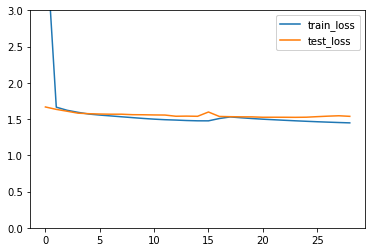

In [13]:
fig, ax = plt.subplots()
line1, = ax.plot(train_loaded, label="train_loss")
line2, = ax.plot(test_loaded, label="test_loss")
ax.set_ylim([0, 3])
# Create a legend for the first line.
first_legend = ax.legend(loc='upper right')
# Add the legend manually to the Axes.
ax.add_artist(first_legend)
plt.show()

In [25]:
import pickle
file_name = "train_loss.pkl"

open_file = open(file_name, "wb")
pickle.dump(train_loss, open_file)
open_file.close()

file_name = "test_loss.pkl"

open_file = open(file_name, "wb")
pickle.dump(test_loss, open_file)
open_file.close()

In [20]:
train_4=train_loaded+train_loss
test_4=test_loaded+test_loss

In [24]:
file_name = "train_loss_4.pkl"
open_file = open(file_name, "wb")
pickle.dump(train_4, open_file)
open_file.close()
file_name = "test_loss_4.pkl"
open_file = open(file_name, "wb")
pickle.dump(test_4, open_file)
open_file.close()

In [114]:
x = torch.tensor([[1, 2, 3, 4, 5, 6, 7],[8,9,10,11,12,13,14]])
x = x.unsqueeze(2).unsqueeze(3)
x = x.repeat(1,1,3,3)
y = x
z = torch.cat((x,y), dim=1)

In [88]:
x = torch.tensor([[[1],[2],[3],[4],[5],[6],[7]],[[8],[9],[10],[11],[12],[13],[14]]])
x = torch.unsqueeze(x, 3)
x

tensor([[[[ 1]],

         [[ 2]],

         [[ 3]],

         [[ 4]],

         [[ 5]],

         [[ 6]],

         [[ 7]]],


        [[[ 8]],

         [[ 9]],

         [[10]],

         [[11]],

         [[12]],

         [[13]],

         [[14]]]])

In [11]:
x=np.zeros((3,3,3,3))
x[:,np.array([0,2]),:].shape

(3, 2, 3, 3)